# Data loader

In [1]:
import monai
from data_loader import MyDataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import EfficientNetBN
import matplotlib.pyplot as plt

from monai.transforms import (
    RandRotate90d,
    RandFlipd,
    RandZoomd,
    RandShiftIntensityd,
)

In [2]:
# custom_augmentations = [
#     RandRotate90d(keys=["image"], prob=0.1, spatial_axes=[0, 2]),
#     RandFlipd(keys=["image"], prob=0.1, spatial_axis=0),
#     RandZoomd(keys=["image"], prob=0.1, min_zoom=0.9, max_zoom=1.1, keep_size=True),
#     RandShiftIntensityd(keys=["image"], prob=0.1, offsets=0.1),
# ]

In [2]:
custom_augmentations = None

In [6]:
dataloader = MyDataLoader(
    csv_path="../../../data/data.csv",          
    input_shape=(128, 128, 128),               
    train_ratio=0.7,                           
    seed=42,
    config={"batch_size": 2, "num_workers": 4},
    transformations=custom_augmentations,      
    num_classes=2                              
)

In [7]:
train_loader = dataloader("train")
test_loader = dataloader("test")

In [8]:
num_train = len(train_loader.dataset)
num_test = len(test_loader.dataset)

print(f"Número de instancias en el conjunto de entrenamiento: {num_train}")
print(f"Número de instancias en el conjunto de prueba: {num_test}")

Número de instancias en el conjunto de entrenamiento: 1050
Número de instancias en el conjunto de prueba: 450


In [6]:
from collections import Counter

def obtener_distribucion_clases(loader):
    contador = Counter()
    for batch in loader:
        labels = batch['label']
        indices_clase = labels.argmax(dim=1).numpy()
        contador.update(indices_clase)
    return contador

distribucion_train = obtener_distribucion_clases(train_loader)
distribucion_test = obtener_distribucion_clases(test_loader)

print(f"Distribución de clases en entrenamiento: {distribucion_train}")
print(f"Distribución de clases en prueba: {distribucion_test}")

Distribución de clases en entrenamiento: Counter({0: 843, 1: 357})
Distribución de clases en prueba: Counter({0: 232, 1: 68})


# Entrenamiento

In [9]:
model = EfficientNetBN(
    spatial_dims=3,
    in_channels=3, 
    num_classes=2,
    model_name='efficientnet-b0',
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

use_class_weights = True 

if use_class_weights:
    class_weights = dataloader.class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(">> Usando pesos de clase:", class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    print(">> Sin pesos de clase")

optimizer = optim.Adam(model.parameters(), lr=1e-5)

epochs = 20
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)
        true_labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, true_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == true_labels).sum().item()
        total_train += true_labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)
            true_labels = torch.argmax(labels, dim=1)

            outputs = model(inputs)
            loss = criterion(outputs, true_labels)
            val_running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == true_labels).sum().item()
            total_val += true_labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_acc = correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"[Epoch {epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

>> Usando pesos de clase: tensor([0.2838, 0.7162], device='cuda:0')
[Epoch 1/20] Train Loss: 1.6895 | Train Acc: 0.4114 || Val Loss: 0.8440 | Val Acc: 0.7178
[Epoch 2/20] Train Loss: 1.2088 | Train Acc: 0.5114 || Val Loss: 3.6354 | Val Acc: 0.5422
[Epoch 3/20] Train Loss: 1.1292 | Train Acc: 0.6019 || Val Loss: 2.0299 | Val Acc: 0.6844
[Epoch 4/20] Train Loss: 1.1055 | Train Acc: 0.6210 || Val Loss: 2.6978 | Val Acc: 0.6756
[Epoch 5/20] Train Loss: 1.0594 | Train Acc: 0.6190 || Val Loss: 2.3844 | Val Acc: 0.6489
[Epoch 6/20] Train Loss: 1.0389 | Train Acc: 0.6105 || Val Loss: 2.8678 | Val Acc: 0.7044
[Epoch 7/20] Train Loss: 1.0423 | Train Acc: 0.6267 || Val Loss: 1.6078 | Val Acc: 0.6222
[Epoch 8/20] Train Loss: 1.0491 | Train Acc: 0.6371 || Val Loss: 1.6876 | Val Acc: 0.6378
[Epoch 9/20] Train Loss: 0.9349 | Train Acc: 0.6543 || Val Loss: 1.5700 | Val Acc: 0.5644
[Epoch 10/20] Train Loss: 0.9222 | Train Acc: 0.6790 || Val Loss: 1.3369 | Val Acc: 0.6022
[Epoch 11/20] Train Loss: 0.942

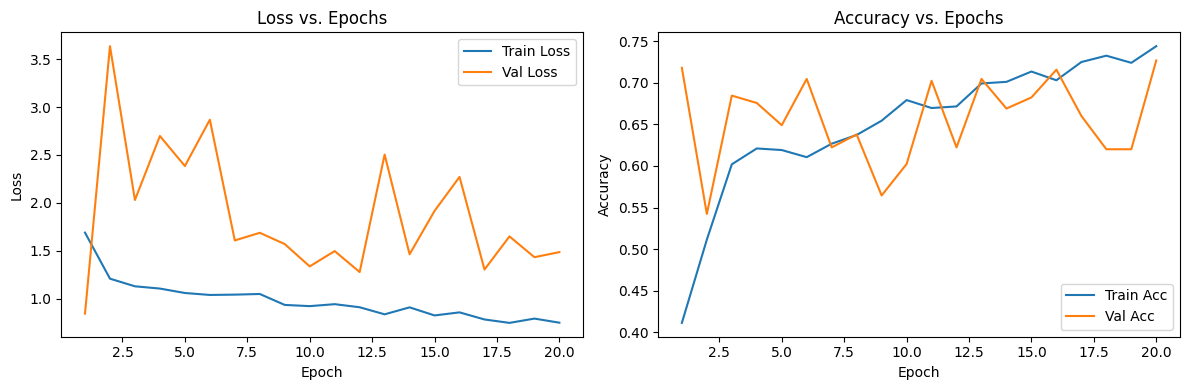

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(range(1, epochs+1), train_loss_history, label="Train Loss")
axs[0].plot(range(1, epochs+1), val_loss_history, label="Val Loss")
axs[0].set_title("Loss vs. Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(range(1, epochs+1), train_acc_history, label="Train Acc")
axs[1].plot(range(1, epochs+1), val_acc_history, label="Val Acc")
axs[1].set_title("Accuracy vs. Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()